# Gauss-Jordan elimination with partial pivoting

| Who  | Mail | Date | What |
| ---  | ---   | --- | ---      |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co>  | May 17th, 2025 | Initial code |

The Gauss-Jordan elimination method is a technique for solving systems of linear equations by transforming the augmented matrix into reduced row echelon form (RREF). This notebook demonstrates the implementation of the Gauss-Jordan elimination algorithm in Python and explores its applications, advantages, and limitations.

Applications of Gauss-Jordan Elimination:
1. Solving systems of linear equations
2. Finding the inverse of a matrix
3. Computing the rank of a matrix (homework)
4. Computing the null space of a matrix (homework)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import pandas as pd
import time

## 1. Mathematical Background

Gauss-Jordan elimination is a systematic procedure for solving systems of linear equations by transforming the augmented matrix into reduced row echelon form (RREF). This method is an extension of Gaussian elimination that continues the row operations until the coefficient matrix becomes the identity matrix.

Consider a system of $n$ linear equations with $n$ unknowns:

$$
\begin{align}
a_{11}x_1 + a_{12}x_2 + \cdots + a_{1n}x_n &= b_1\\
a_{21}x_1 + a_{22}x_2 + \cdots + a_{2n}x_n &= b_2\\
\vdots\\
a_{n1}x_1 + a_{n2}x_2 + \cdots + a_{nn}x_n &= b_n
\end{align}
$$

This system can be represented in matrix form as $\boldsymbol{A}\boldsymbol{x} = \boldsymbol{b}$, where:

$$\boldsymbol{A} = 
\begin{bmatrix} 
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}, 
\quad \boldsymbol{x} = 
\begin{bmatrix} 
x_1 \\
x_2 \\
\vdots \\
x_n
\end{bmatrix}, 
\quad \boldsymbol{b} = 
\begin{bmatrix} 
b_1 \\
b_2 \\
\vdots \\
b_n
\end{bmatrix}
$$

The augmented matrix combines $\boldsymbol{A}$ and $\boldsymbol{b}$:

$$[\boldsymbol{A}|\boldsymbol{b}] = 
\begin{bmatrix} 
a_{11} & a_{12} & \cdots & a_{1n} & b_1 \\
a_{21} & a_{22} & \cdots & a_{2n} & b_2 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn} & b_n
\end{bmatrix}
$$

### Gauss-Jordan Algorithm

The Gauss-Jordan method transforms the augmented matrix into reduced row echelon form through elementary row operations:

1. **Pivoting and swapping**:
Select the element with the largest absolute value in the current column (partial pivoting). Then swap the actual row with the pivot row. In other words, for column $j$, find the row $i \geq j$ with the largest absolute value in position $(i,j)$. This helps minimize round-off errors. Then swap the actual row with the pivot row. In matrix notation, if $p$ is the pivot row:

$$R_j \leftrightarrow R_p$$

2. **Scaling**: 
Divide the pivot row $j$ by the pivot element $a_{jj}$ to make the pivot element 1:

$$R_j \rightarrow \frac{1}{a_{jj}} R_j$$

3. **Elimination**: Subtract multiples of the pivot row from all other rows to create zeros above and below the pivot. For each row $i \neq j$, subtract $a_{ij}$ times the pivot row from row $i$:

$$R_i \rightarrow R_i - a_{ij} R_j$$

Repeat these steps for each column $j = 1, 2, \ldots, n$.


The goal is to transform the augmented matrix into the form:

$$
\begin{bmatrix} 
1 & 0 & \cdots & 0 & c_1 \\
0 & 1 & \cdots & 0 & c_2 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & 1 & c_n
\end{bmatrix}
$$

where the solution vector $\boldsymbol{x} = [c_1, c_2, \ldots, c_n]^T$.




## 2. Implementation of the Gauss-Jordan elimination method

### 2.1 Visualization Functions

In [2]:
def print_matrix(matrix, precision=4):
    """Pretty print an augmented matrix with colored-blue last column"""
    m, n = matrix.shape

    assert (n == m+1) or (n == 2*m), "matrix's size not supported" 
    
    df = pd.DataFrame(np.round(matrix, precision))
    df.index += 1 

    if n == m+1:
        df.columns = [f'A[:,{i}]' for i in range(1, n)] + ['b']
    elif n == 2*m:
        df.columns = [f'A[:,{i}]' for i in range(1, m+1)] + [f'A⁻¹[:,{i}]' for i in range(1, m+1)]
    
    # Adjust the display
    pd.set_option('display.max_columns', None)  # print an unlimited number of columns
    pd.set_option('display.width', None)        # width of the display in characters
    
    # Apply the style to the last columns
    def highlight_last_column(s):
        return ['background-color: lightblue' if s.name=='b' or s.name[:3]=='A⁻¹' else '' for _ in s]
    
    return df.style.apply(highlight_last_column, axis=0)

### 2.2 Implementation

In [3]:
def gauss_jordan_elimination(A, b, show_steps=False):
    """
    Solve a system of linear equations using Gauss-Jordan elimination.
    Can show intermediate steps of the augmented matrix.
    
    Parameters:
        A (numpy.ndarray): Coefficient matrix of shape (n, n)
        b (numpy.ndarray): Right-hand side vector of shape (n,) or matrix (n, m)
        show_steps (bool): Whether to print intermediate steps
    
    Returns:
        numpy.ndarray: Solution vector x of shape (n,)
    """
    # Check if A is square
    n, m = A.shape
    if n != m:
        raise ValueError("Coefficient matrix A must be square")
    
    # Check if b has compatible dimensions
    if b.shape[0] != m:
        raise ValueError("Dimensions of A and b must be compatible")
    
    # Create the augmented matrix [A|b]
    augmented = np.column_stack((A.astype(np.float64), b.astype(np.float64)))
   
    if show_steps:
        print("Initial augmented matrix:")
        display(print_matrix(augmented))
        print("-" * 40)
    
    # Gauss-Jordan elimination process
    for j in range(n):
        # Find the pivot row (row with the largest absolute value in column j)
        pivot_row = j + np.argmax(abs(augmented[j:n, j]))
        # pivot_row = j
        # for i in range(j + 1, n):
        #     if abs(augmented[i, j]) > abs(augmented[pivot_row, j]):
        #          pivot_row = i
        
        # Swap the current row with the pivot row
        if pivot_row != j:
            augmented[[j, pivot_row]] = augmented[[pivot_row, j]]
            if show_steps:
                print(f"Swap rows {j+1} and {pivot_row+1}:")
                display(print_matrix(augmented))
                print("-" * 40)
        
        # Check if matrix is singular
        pivot = augmented[j, j]
        if abs(pivot) < 1e-10:
            raise ValueError("Matrix is singular or nearly singular")
        
        # Scale the pivot row to make the pivot element 1
        augmented[j] = augmented[j]/pivot
        if show_steps:
            print(f"Scale row {j+1} by 1/{pivot:.4f}:")
            display(print_matrix(augmented))
            print("-" * 40)
        
        # Eliminate other rows
        for i in range(n):
            if i != j:
                factor = augmented[i, j]
                if abs(factor) > 1e-10:  # Only perform elimination if necessary
                    augmented[i] = augmented[i] - factor*augmented[j]
                    if show_steps:
                        print(f"Subtract {factor:.4f} times row {j+1} from row {i+1}:")
                        display(print_matrix(augmented))
                        print("-" * 40)

    if show_steps:
        print("Final reduced row echelon form:")
        display(print_matrix(augmented))
        print("-" * 40)
       
    # Extract the solution or the inverse matrix (right half of augmented matrix)
    x = augmented[:, n:]   
    
    return x

## 3. Examples

### Example 1: Solving a simple 3x3 system

In [4]:
A = np.array([
    [ 2,  1, -1],
    [-3, -1,  2],
    [-2,  7,  2]
])

x = np.array([8, -11, -3])

b = A@x

print("\nCoefficient matrix A:")
print(A)
print("\nRight-hand side vector b:")
print(b)

print("\nAugmented system:")
print_matrix(np.column_stack((A, b)))


Coefficient matrix A:
[[ 2  1 -1]
 [-3 -1  2]
 [-2  7  2]]

Right-hand side vector b:
[  8 -19 -99]

Augmented system:


,"A[:,1]","A[:,2]","A[:,3]",b
1,2,1,-1,8
2,-3,-1,2,-19
3,-2,7,2,-99


In [5]:
try:
    x = gauss_jordan_elimination(A, b)
    print("\nSolution using our Gauss-Jordan implementation:")
    print(x)
    
    # Verify the solution
    print("\nVerification A*x:")
    print(A@x)
    
    # Compare with NumPy's built-in solver
    x_numpy = np.linalg.solve(A, b)
    print("\nSolution using NumPy's solver:")
    print(x_numpy)
    
    # Check if solutions are close
    print(f"\nOur solution matches NumPy's: {np.allclose(x, x_numpy)}")
    
except ValueError as error:
    print(f"Error: {error}")

# Condition number analysis
cond = np.linalg.cond(A)
print(f"\nCondition number of matrix: {cond:.2f}")
if cond < 100:
    print("The system is well-conditioned.")
else:
    print("The system is poorly conditioned; this may lead to numerical instability.")    


Solution using our Gauss-Jordan implementation:
[[  8.]
 [-11.]
 [ -3.]]

Verification A*x:
[[  8.]
 [-19.]
 [-99.]]

Solution using NumPy's solver:
[  8. -11.  -3.]

Our solution matches NumPy's: False

Condition number of matrix: 36.32
The system is well-conditioned.


In [6]:
x = gauss_jordan_elimination(A, b, show_steps=True)

Initial augmented matrix:


,"A[:,1]","A[:,2]","A[:,3]",b
1,2.000000,1.000000,-1.000000,8.000000
2,-3.000000,-1.000000,2.000000,-19.000000
3,-2.000000,7.000000,2.000000,-99.000000


----------------------------------------
Swap rows 1 and 2:


,"A[:,1]","A[:,2]","A[:,3]",b
1,-3.000000,-1.000000,2.000000,-19.000000
2,2.000000,1.000000,-1.000000,8.000000
3,-2.000000,7.000000,2.000000,-99.000000


----------------------------------------
Scale row 1 by 1/-3.0000:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.333300,-0.666700,6.333300
2,2.000000,1.000000,-1.000000,8.000000
3,-2.000000,7.000000,2.000000,-99.000000


----------------------------------------
Subtract 2.0000 times row 1 from row 2:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.333300,-0.666700,6.333300
2,0.000000,0.333300,0.333300,-4.666700
3,-2.000000,7.000000,2.000000,-99.000000


----------------------------------------
Subtract -2.0000 times row 1 from row 3:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.333300,-0.666700,6.333300
2,0.000000,0.333300,0.333300,-4.666700
3,0.000000,7.666700,0.666700,-86.333300


----------------------------------------
Swap rows 2 and 3:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.333300,-0.666700,6.333300
2,0.000000,7.666700,0.666700,-86.333300
3,0.000000,0.333300,0.333300,-4.666700


----------------------------------------
Scale row 2 by 1/7.6667:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.333300,-0.666700,6.333300
2,0.000000,1.000000,0.087000,-11.260900
3,0.000000,0.333300,0.333300,-4.666700


----------------------------------------
Subtract 0.3333 times row 2 from row 1:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.000000,-0.695700,10.087000
2,0.000000,1.000000,0.087000,-11.260900
3,0.000000,0.333300,0.333300,-4.666700


----------------------------------------
Subtract 0.3333 times row 2 from row 3:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.000000,-0.695700,10.087000
2,0.000000,1.000000,0.087000,-11.260900
3,0.000000,0.000000,0.304300,-0.913000


----------------------------------------
Scale row 3 by 1/0.3043:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.000000,-0.695700,10.087000
2,0.000000,1.000000,0.087000,-11.260900
3,0.000000,0.000000,1.000000,-3.000000


----------------------------------------
Subtract -0.6957 times row 3 from row 1:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.000000,0.000000,8.000000
2,0.000000,1.000000,0.087000,-11.260900
3,0.000000,0.000000,1.000000,-3.000000


----------------------------------------
Subtract 0.0870 times row 3 from row 2:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.000000,0.000000,8.000000
2,0.000000,1.000000,0.000000,-11.000000
3,0.000000,0.000000,1.000000,-3.000000


----------------------------------------
Final reduced row echelon form:


,"A[:,1]","A[:,2]","A[:,3]",b
1,1.000000,0.000000,0.000000,8.000000
2,0.000000,1.000000,0.000000,-11.000000
3,0.000000,0.000000,1.000000,-3.000000


----------------------------------------


### Example 2: Ill-conditioned system

In [7]:
A = np.array([
    [1, 1],
    [1, 1.000000000000000001]
])

b = np.array([2, 2.000000000000000001])

print("\n\nIll-conditioned system")
print("Coefficient matrix A:")
print(A)
print("\nRight-hand side vector b:")
print(b)

try:
    x = gauss_jordan_elimination(A, b)
    print("\nSolution using our Gauss-Jordan implementation:")
    print(x)
    
    # Verify the solution
    print("\nVerification A*x:")
    print(A@x)
    
    # Compare with NumPy's built-in solver
    x_numpy = np.linalg.solve(A, b)
    print("\nSolution using NumPy's solver:")
    print(x_numpy)
    
except ValueError as error:
    print(f"Error: {error}")

# Condition number analysis
cond = np.linalg.cond(A)
print(f"\nCondition number of matrix: {cond:.2f}")
if cond < 100:
    print("The system is well-conditioned.")
else:
    print("The system is poorly conditioned; this may lead to numerical instability.")



Ill-conditioned system
Coefficient matrix A:
[[1. 1.]
 [1. 1.]]

Right-hand side vector b:
[2. 2.]
Error: Matrix is singular or nearly singular

Condition number of matrix: 59617770476389832.00
The system is poorly conditioned; this may lead to numerical instability.


## 4. Large System Performance

In [8]:
def compare_performance(sizes):
    """
    Compare performance of our implementation versus NumPy for different matrix sizes.
    """
    
    num_sizes = len(sizes)

    # Separate memory
    gj_times     = np.zeros(num_sizes)
    np_times     = np.zeros(num_sizes)
    gj_residuals = np.zeros(num_sizes)
    np_residuals = np.zeros(num_sizes)

    # Create a seed for reproducibility
    np.random.seed(42)

    for i in range(num_sizes):
        # Matrix size
        n = sizes[i]
        
        # Generate a random matrix
        A = np.random.rand(n, n)

        # Create a known solution
        x_true = np.random.rand(n) * 10

        # Compute the right-hand side
        b = A@x_true

        # Time our implementation
        start = time.perf_counter()
        try:
            start = time.perf_counter()            
            x_gj = gauss_jordan_elimination(A, b)
            gj_times[i] = time.perf_counter() - start
        except Exception as error:
            print(f"Gauss-Jordan failed: {error}")
            gj_times[i] = np.nan

        # Time NumPy's implementation
        start = time.perf_counter()
        x_np = np.linalg.solve(A, b)
        np_times[i] = time.perf_counter() - start

        # Check if solution satisfies the original system
        gj_residuals[i] = np.linalg.norm(A@x_gj - b)
        np_residuals[i] = np.linalg.norm(A@x_np - b)

    # Pack all stats in a Pandas' dataframe
    df = pd.DataFrame({
        'Size':           sizes,
        'Time GJ':        gj_times,
        'Time NumPy':     np_times,
        'Residual GJ':    gj_residuals,
        'Residual NumPy': np_residuals
    })
    return df

In [9]:
# Compare performance for matrices of different sizes
print("\n\nPerformance Comparison:")
sizes = [10, 20, 50, 100, 200, 500, 1000, 2000]
df = compare_performance(sizes)
display(df)



Performance Comparison:


,Size,Time GJ,Time NumPy,Residual GJ,Residual NumPy
0,10,0.004820,0.000227,32.335284,5.024296e-15
1,20,0.002673,0.000182,163.165523,2.751920e-14
2,50,0.015090,0.000312,763.347314,1.406803e-13
3,100,0.045162,0.000397,1884.367518,4.167441e-13
4,200,0.113299,0.001589,6661.903678,3.352798e-12
5,500,0.888465,0.003980,25846.198257,2.464147e-11
6,1000,4.245950,0.036077,72505.819219,9.597324e-11
7,2000,30.569842,0.154800,212109.227762,4.597664e-10


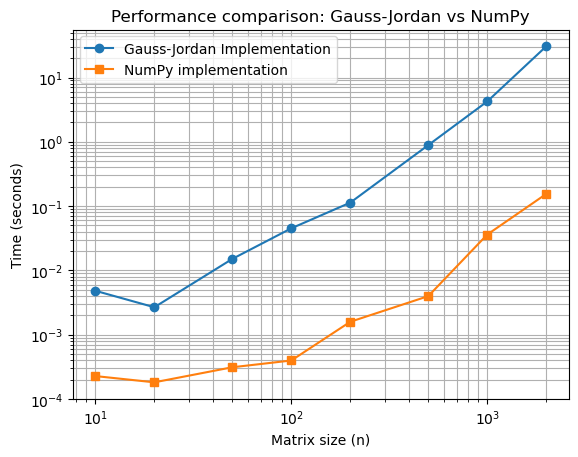

In [10]:
# Plot the performance comparison
gj_times = df['Time GJ']
np_times = df['Time NumPy']

plt.loglog(sizes, gj_times, 'o-', label='Gauss-Jordan Implementation')
plt.loglog(sizes, np_times, 's-', label='NumPy implementation')
plt.xlabel('Matrix size (n)')
plt.ylabel('Time (seconds)')
plt.title('Performance comparison: Gauss-Jordan vs NumPy')
plt.legend()
plt.grid(True, which="both")
#k, log_a = np.polyfit(np.log(sizes[4:]), np.log(gj_times[4:]), 1)
#plt.plot(sizes, np.exp(log_a)*sizes**k)
plt.show()

When data follows a straight line in a log-log plot, it indicates that the relationship between the two variables adheres to a *power law*. Specifically, the data can be modeled by an equation of the form 
$$y = ax^k.$$
To show that, take the logarithm of both sides of the power law equation transforms it into:
$$
   \log(y) = \log(a) + k\log(x).
$$
This is a linear equation where $k$ is the slope of the line and $\log(a)$ is the intercept.

In [11]:
k, log_a = np.polyfit(np.log(sizes[4:]), np.log(gj_times[4:]), 1)
print("k =", k)
print("a =", np.exp(log_a))

k = 2.407859960032045
a = 2.99370646956263e-07


## 5. Computing the Inverse of a Matrix using Gauss-Jordan

In [12]:
def matrix_inverse_gauss_jordan(A, show_steps=False):
    """
    Compute the inverse of a matrix using Gauss-Jordan elimination.
    
    Parameters:
    A (numpy.ndarray): Square matrix to invert
    show_steps (bool): Whether to print intermediate steps
    
    
    Returns:
    numpy.ndarray: Inverse of matrix A    
    """
    
    # Check if A is square
    n, m = A.shape
    if n != m:
        raise ValueError("Coefficient matrix A must be square")

    inverse = gauss_jordan_elimination(A, np.eye(n), show_steps)
    return inverse

### Example: computing a matrix inverse

In [13]:
A = np.array([
    [ 2,  1, -1, 5],
    [-3, -1,  2, 4],
    [-2,  7,  2, 8],
    [ 4,  2,  1, 3],
])

print("\n\nExample: Computing a matrix inverse")
print("Original matrix:")
print(A)


inv_A = matrix_inverse_gauss_jordan(A)
try:
    inv_A = matrix_inverse_gauss_jordan(A, show_steps=True)
    print("\nInverse using our Gauss-Jordan implementation:")
    print(inv_A)
    
    # Verify the inverse: A*A⁻¹ = I
    print("\nVerification A*A⁻¹:")
    print(A@inv_A)
    
    # Compare with NumPy's built-in inverse
    numpy_inv_A = np.linalg.inv(A)
    print("\nInverse using NumPy:")
    print(numpy_inv_A)
    
    # Check if solutions are close
    print(f"\nOur inverse matches NumPy's: {np.allclose(inv_A, numpy_inv_A)}")
    
except ValueError as error:
    print(f"Error: {error}")



Example: Computing a matrix inverse
Original matrix:
[[ 2  1 -1  5]
 [-3 -1  2  4]
 [-2  7  2  8]
 [ 4  2  1  3]]
Initial augmented matrix:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,2.000000,1.000000,-1.000000,5.000000,1.000000,0.000000,0.000000,0.000000
2,-3.000000,-1.000000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000
3,-2.000000,7.000000,2.000000,8.000000,0.000000,0.000000,1.000000,0.000000
4,4.000000,2.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000


----------------------------------------
Swap rows 1 and 4:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,4.000000,2.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000
2,-3.000000,-1.000000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000
3,-2.000000,7.000000,2.000000,8.000000,0.000000,0.000000,1.000000,0.000000
4,2.000000,1.000000,-1.000000,5.000000,1.000000,0.000000,0.000000,0.000000


----------------------------------------
Scale row 1 by 1/4.0000:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.500000,0.250000,0.750000,0.000000,0.000000,0.000000,0.250000
2,-3.000000,-1.000000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000
3,-2.000000,7.000000,2.000000,8.000000,0.000000,0.000000,1.000000,0.000000
4,2.000000,1.000000,-1.000000,5.000000,1.000000,0.000000,0.000000,0.000000


----------------------------------------
Subtract -3.0000 times row 1 from row 2:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.500000,0.250000,0.750000,0.000000,0.000000,0.000000,0.250000
2,0.000000,0.500000,2.750000,6.250000,0.000000,1.000000,0.000000,0.750000
3,-2.000000,7.000000,2.000000,8.000000,0.000000,0.000000,1.000000,0.000000
4,2.000000,1.000000,-1.000000,5.000000,1.000000,0.000000,0.000000,0.000000


----------------------------------------
Subtract -2.0000 times row 1 from row 3:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.500000,0.250000,0.750000,0.000000,0.000000,0.000000,0.250000
2,0.000000,0.500000,2.750000,6.250000,0.000000,1.000000,0.000000,0.750000
3,0.000000,8.000000,2.500000,9.500000,0.000000,0.000000,1.000000,0.500000
4,2.000000,1.000000,-1.000000,5.000000,1.000000,0.000000,0.000000,0.000000


----------------------------------------
Subtract 2.0000 times row 1 from row 4:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.500000,0.250000,0.750000,0.000000,0.000000,0.000000,0.250000
2,0.000000,0.500000,2.750000,6.250000,0.000000,1.000000,0.000000,0.750000
3,0.000000,8.000000,2.500000,9.500000,0.000000,0.000000,1.000000,0.500000
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Swap rows 2 and 3:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.500000,0.250000,0.750000,0.000000,0.000000,0.000000,0.250000
2,0.000000,8.000000,2.500000,9.500000,0.000000,0.000000,1.000000,0.500000
3,0.000000,0.500000,2.750000,6.250000,0.000000,1.000000,0.000000,0.750000
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Scale row 2 by 1/8.0000:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.500000,0.250000,0.750000,0.000000,0.000000,0.000000,0.250000
2,0.000000,1.000000,0.312500,1.187500,0.000000,0.000000,0.125000,0.062500
3,0.000000,0.500000,2.750000,6.250000,0.000000,1.000000,0.000000,0.750000
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Subtract 0.5000 times row 2 from row 1:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.093800,0.156200,0.000000,0.000000,-0.062500,0.218800
2,0.000000,1.000000,0.312500,1.187500,0.000000,0.000000,0.125000,0.062500
3,0.000000,0.500000,2.750000,6.250000,0.000000,1.000000,0.000000,0.750000
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Subtract 0.5000 times row 2 from row 3:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.093800,0.156200,0.000000,0.000000,-0.062500,0.218800
2,0.000000,1.000000,0.312500,1.187500,0.000000,0.000000,0.125000,0.062500
3,0.000000,0.000000,2.593800,5.656200,0.000000,1.000000,-0.062500,0.718800
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Scale row 3 by 1/2.5938:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.093800,0.156200,0.000000,0.000000,-0.062500,0.218800
2,0.000000,1.000000,0.312500,1.187500,0.000000,0.000000,0.125000,0.062500
3,0.000000,0.000000,1.000000,2.180700,0.000000,0.385500,-0.024100,0.277100
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Subtract 0.0938 times row 3 from row 1:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,-0.048200,0.000000,-0.036100,-0.060200,0.192800
2,0.000000,1.000000,0.312500,1.187500,0.000000,0.000000,0.125000,0.062500
3,0.000000,0.000000,1.000000,2.180700,0.000000,0.385500,-0.024100,0.277100
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Subtract 0.3125 times row 3 from row 2:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,-0.048200,0.000000,-0.036100,-0.060200,0.192800
2,0.000000,1.000000,0.000000,0.506000,0.000000,-0.120500,0.132500,-0.024100
3,0.000000,0.000000,1.000000,2.180700,0.000000,0.385500,-0.024100,0.277100
4,0.000000,0.000000,-1.500000,3.500000,1.000000,0.000000,0.000000,-0.500000


----------------------------------------
Subtract -1.5000 times row 3 from row 4:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,-0.048200,0.000000,-0.036100,-0.060200,0.192800
2,0.000000,1.000000,0.000000,0.506000,0.000000,-0.120500,0.132500,-0.024100
3,0.000000,0.000000,1.000000,2.180700,0.000000,0.385500,-0.024100,0.277100
4,0.000000,0.000000,0.000000,6.771100,1.000000,0.578300,-0.036100,-0.084300


----------------------------------------
Scale row 4 by 1/6.7711:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,-0.048200,0.000000,-0.036100,-0.060200,0.192800
2,0.000000,1.000000,0.000000,0.506000,0.000000,-0.120500,0.132500,-0.024100
3,0.000000,0.000000,1.000000,2.180700,0.000000,0.385500,-0.024100,0.277100
4,0.000000,0.000000,0.000000,1.000000,0.147700,0.085400,-0.005300,-0.012500


----------------------------------------
Subtract -0.0482 times row 4 from row 1:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,0.000000,0.007100,-0.032000,-0.060500,0.192200
2,0.000000,1.000000,0.000000,0.506000,0.000000,-0.120500,0.132500,-0.024100
3,0.000000,0.000000,1.000000,2.180700,0.000000,0.385500,-0.024100,0.277100
4,0.000000,0.000000,0.000000,1.000000,0.147700,0.085400,-0.005300,-0.012500


----------------------------------------
Subtract 0.5060 times row 4 from row 2:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,0.000000,0.007100,-0.032000,-0.060500,0.192200
2,0.000000,1.000000,0.000000,0.000000,-0.074700,-0.163700,0.135200,-0.017800
3,0.000000,0.000000,1.000000,2.180700,0.000000,0.385500,-0.024100,0.277100
4,0.000000,0.000000,0.000000,1.000000,0.147700,0.085400,-0.005300,-0.012500


----------------------------------------
Subtract 2.1807 times row 4 from row 3:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,0.000000,0.007100,-0.032000,-0.060500,0.192200
2,0.000000,1.000000,0.000000,0.000000,-0.074700,-0.163700,0.135200,-0.017800
3,0.000000,0.000000,1.000000,0.000000,-0.322100,0.199300,-0.012500,0.304300
4,0.000000,0.000000,0.000000,1.000000,0.147700,0.085400,-0.005300,-0.012500


----------------------------------------
Final reduced row echelon form:


,"A[:,1]","A[:,2]","A[:,3]","A[:,4]","A⁻¹[:,1]","A⁻¹[:,2]","A⁻¹[:,3]","A⁻¹[:,4]"
1,1.000000,0.000000,0.000000,0.000000,0.007100,-0.032000,-0.060500,0.192200
2,0.000000,1.000000,0.000000,0.000000,-0.074700,-0.163700,0.135200,-0.017800
3,0.000000,0.000000,1.000000,0.000000,-0.322100,0.199300,-0.012500,0.304300
4,0.000000,0.000000,0.000000,1.000000,0.147700,0.085400,-0.005300,-0.012500


----------------------------------------

Inverse using our Gauss-Jordan implementation:
[[ 0.00711744 -0.03202847 -0.06049822  0.19217082]
 [-0.0747331  -0.16370107  0.13523132 -0.01779359]
 [-0.32206406  0.19928826 -0.01245552  0.30427046]
 [ 0.14768683  0.08540925 -0.00533808 -0.01245552]]

Verification A*A⁻¹:
[[ 1.00000000e+00  1.11022302e-16  0.00000000e+00  2.77555756e-17]
 [-1.11022302e-16  1.00000000e+00 -2.77555756e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  5.55111512e-17]
 [ 0.00000000e+00 -1.38777878e-17  0.00000000e+00  1.00000000e+00]]

Inverse using NumPy:
[[ 0.00711744 -0.03202847 -0.06049822  0.19217082]
 [-0.0747331  -0.16370107  0.13523132 -0.01779359]
 [-0.32206406  0.19928826 -0.01245552  0.30427046]
 [ 0.14768683  0.08540925 -0.00533808 -0.01245552]]

Our inverse matches NumPy's: True
